## This notebook describes my solution for the Kaggle Titanic Challenge   

First, start with the necessary imports

In [1]:
# Import division from future
from __future__ import division

# Basic analysis imports
import pandas as pd
from pandas import Series,DataFrame
from pandas.tools import plotting
import numpy as np

# Scikitlearn imports
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc

# Standard visualization analysis imports
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')
%matplotlib inline

Read in and combine training and test datasets so that all feature engineering is done to both equally

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
# Extract and remove target data from training set
target = train.Survived
train.drop('Survived', axis=1, inplace=True)
# Combine training and testing data
combined_df = train.append(test)
combined_df.reset_index(inplace=True)
combined_df.drop('index', axis=1, inplace=True)
# Take a quick look
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


There are many missing values in the Age and Cabin columns as well as one in the Embarked column. To ameliorate this, when processing the raw dataset to form meaningful features for machine learning I fill in the missing values with the corresponding medians as below. Also, I form dummy variables for all categorical features.

In [3]:
def process_features():
    
    # Load combined dataframe
    global combined_df
    
    '''
    Each name starts with a title of some kind. I'll create a dummy variable for each separate title. 
    Since some titles are very similar to others, I'll create a reduced list to map to.
    '''
    title_list = list(np.unique([name.split(', ')[1].split('.')[0] for name in combined_df.Name]))
    title_map = {
                        'Capt': 'Military',
                        'Col': 'Military',
                        'Major': 'Military',
                        'Don': 'Royalty',
                        'Dona': 'Royalty',
                        'Jonkheer': 'Royalty',
                        'the Countess': 'Royalty',
                        'Sir': 'Royalty',
                        'Lady': 'Royalty',
                        'Master': 'Royalty',
                        'Dr': 'Academic',
                        'Rev': 'Academic',
                        'Mlle': 'Miss',
                        'Miss': 'Miss',
                        'Mme': 'Mrs',
                        'Mrs': 'Mrs',
                        'Ms': 'Mrs',
                        'Mr': 'Mr'
                    }
    # Create a Title column
    combined_df['Title'] = combined_df.Name.map(lambda x: x.split(', ')[1].split('.')[0])
    # Map to reduced list of titles
    combined_df.Title = combined_df.Title.map(title_map)
    # Create dummy columns for titles. ***Keep the dummy title for the time being, we'll drop in a second***
    title_dummies = pd.get_dummies(combined_df.Title, prefix='Title')
    combined_df = pd.concat([combined_df, title_dummies], axis=1)
    # Drop Name column
    combined_df.drop('Name', axis=1, inplace=True)
    
    '''
    I fill in the missing age values based on the median value organized by Sex, Class, and Title.
    '''
    # Fill in missing age values
    age_groups = combined_df.groupby(['Sex', 'Pclass', 'Title'])['Age'].median()
    # Define a function to map to correct median age based on sex, class, and title
    def process_age(row):
        if np.isnan(row.Age):
            age = age_groups[row.Sex, row.Pclass, row.Title]
        else:
            age = row.Age 
        return age
    combined_df.Age = combined_df.apply(process_age, axis=1)
    
    '''
    I fill in the missing fare values based on the median value organized by Sex, Class, and Title.
    '''
    # Fill in missing fare values
    fare_groups = combined_df.groupby(['Sex', 'Pclass', 'Title'])['Fare'].median()
    def process_fare(row):
        if np.isnan(row.Fare):
            fare = fare_groups[row.Sex, row.Pclass, row.Title]
        else:
            fare = row.Fare 
        return fare
    combined_df.Fare = combined_df.apply(process_fare, axis=1)
    
    '''
    Since the vast majority of people embarked from Southampton, I'll just assume all missing values are 'S'
    '''
    combined_df.Embarked.fillna('S', inplace=True)
    embarked_dummies = pd.get_dummies(combined_df.Embarked, prefix='Embarked')
    combined_df = pd.concat([combined_df, embarked_dummies], axis=1)
    combined_df.drop('Embarked', axis=1, inplace=True)
    
    '''
    I define dummy variables based on which deck they were on (which is the first letter of their cabin number).
    Also, if the cabin number is missing, then I fill it with U for unknown.
    '''
    # Fill missing cabin values with 'U' for unknown
    combined_df.Cabin.fillna('U', inplace=True)
    # Extract first letter of cabin values to act as the Deck the passenger was assigned to
    combined_df['Deck'] = combined_df.Cabin.map(lambda x: x[0])
    # Use dummy encoding
    deck_dummies = pd.get_dummies(combined_df.Deck, prefix='Deck')
    combined_df = pd.concat([combined_df, deck_dummies], axis=1)
    combined_df.drop('Cabin', axis=1, inplace=True)
    
    '''
    Process Sex feature
    '''
    combined_df.Sex = combined_df.Sex.map({'male':1, 'female':0})
    
    '''
    Create dummy features for Class
    '''
    class_dummies = pd.get_dummies(combined_df.Pclass, prefix='Pclass')
    combined_df = pd.concat([combined_df, class_dummies], axis=1)
    
    '''
    The prefix for the ticket number can be another identifying feature so we'll create a set of dummy variables
    for it.
    '''
    def clean_ticket(ticket):
        ticket = ticket.replace('/', '').replace('.', '').split()
        ticket = [x.strip() for x in ticket]
        ticket = filter(lambda x: not x.isdigit(), ticket)
        if len(ticket) > 0:
            return ticket[0]
        else:
            return 'XXX'

    combined_df['Ticket'] = combined_df.Ticket.map(clean_ticket)
    ticket_dummies = pd.get_dummies(combined_df.Ticket, prefix='Ticket')
    combined_df = pd.concat([combined_df, ticket_dummies], axis=1)
    combined_df.drop('Ticket', axis=1, inplace=True)
    
    '''
    We can also create a family feature which can be translated into 3 separate dummy variables for single, 
    small, and large family.
    '''
    combined_df['Family'] = combined_df.SibSp + combined_df.Parch
    def family_map(size):
        if size == 1:
            return 'Single'
        elif (size > 1) and (size <= 4):
            return 'Small'
        else:
            return 'Large'
    combined_df.Family = combined_df.Family.map(family_map)
    family_dummies = pd.get_dummies(combined_df.Family, prefix='Family')
    combined_df = pd.concat([combined_df, family_dummies], axis=1)
    
    # Break up the dataset again into a training and testing set
    train_df = combined_df.loc[ 0:(train.shape[0]-1) ]
    test_df = combined_df.loc[ train.shape[0]:(train.shape[0] + test.shape[0]) ]
    
    return train_df, test_df
    
# Process all features
train_df, test_df = process_features()

We can now make some visualizations of the most important features to see how they affect survival

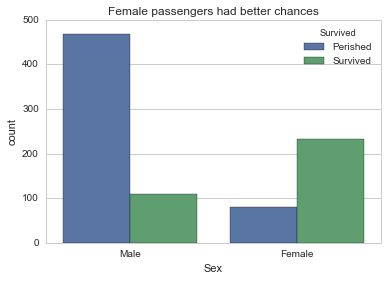

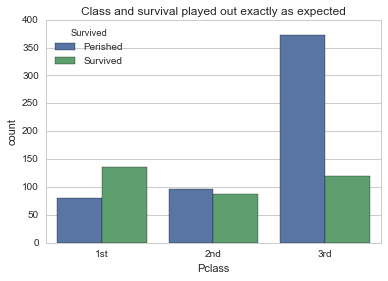

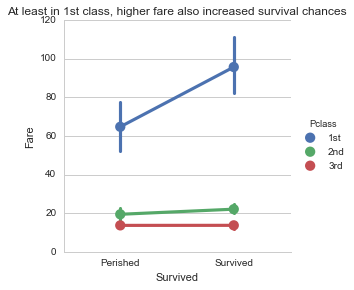

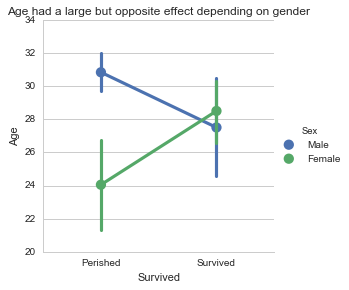

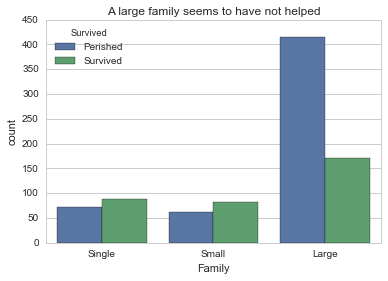

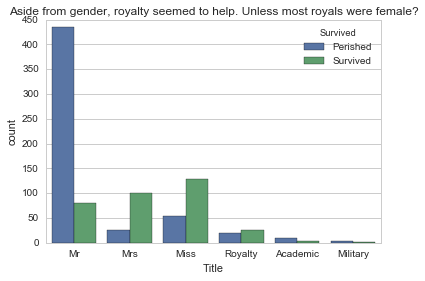

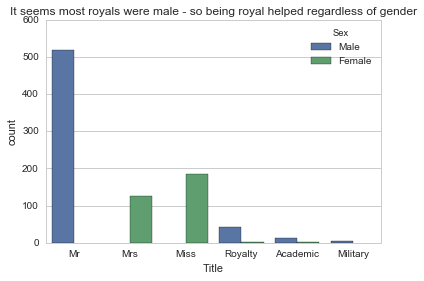

In [4]:
# First create a dataframe of some features for visualization and concatenate the survival results
cols = ['Pclass', 'Age', 'Fare', 'Title', 'Deck', 'Family', 'Sex']
vis_df = DataFrame(train_df, columns=cols)
vis_df['Survived'] = target
sex_map = {0:'Female', 1:'Male'}
survival_map = {0:'Perished', 1:'Survived'}
class_map = {1:'1st', 2:'2nd', 3:'3rd'}
vis_df.Sex = vis_df.Sex.map(sex_map)
vis_df.Survived = vis_df.Survived.map(survival_map)
vis_df.Pclass = vis_df.Pclass.map(class_map)

# Create visualizations
sb.countplot(x='Sex', hue='Survived', data=vis_df)
plt.title('Female passengers had better chances')
plt.show()

sb.countplot(x='Pclass', hue='Survived', data=vis_df, order=['1st', '2nd', '3rd'])
plt.title('Class and survival played out exactly as expected')
plt.show()

sb.factorplot(x='Survived', y='Fare', hue='Pclass', data=vis_df, hue_order=['1st', '2nd', '3rd'])
plt.title('At least in 1st class, higher fare also increased survival chances')
plt.show()

sb.factorplot(x='Survived', y='Age', hue='Sex', data=vis_df)
plt.title('Age had a large but opposite effect depending on gender')
plt.show()

sb.countplot(x='Family', hue='Survived', data=vis_df, order=['Single', 'Small', 'Large'])
plt.title('A large family seems to have not helped')
plt.show()

sb.countplot(x='Title', hue='Survived', data=vis_df)
plt.title('Aside from gender, royalty seemed to help. Unless most royals were female?')
plt.show()

sb.countplot(x='Title', hue='Sex', data=vis_df)
plt.title('It seems most royals were male - so being royal helped regardless of gender')
plt.show()

Now I take the original combined dataframe and drop columns that aren't needed anymore and normalize features

In [5]:
# Drop columns for which dummy columns exist from the combined dataframe
combined_df = combined_df.drop(['Title', 'Deck', 'Family', 'Pclass'], axis=1)

# Rescale all features to exist within the unit interval
feature_list = list(combined_df.columns)
feature_list.remove('PassengerId')
combined_df[ feature_list ] = combined_df[ feature_list ].apply(lambda x: x/x.max(), axis=0)

# Split the combined dataframe into a train and test set again
train_df = combined_df.loc[ 0:(train.shape[0]-1) ]
test_df = combined_df.loc[ train.shape[0]:(train.shape[0] + test.shape[0]) ]

Here, I perform feature selection which helps to reduce redundancy in the data, speeds up training, and reduces overfitting.

In [6]:
# Perform feature selection using a tree-based estimator. The threshold for selection is by default set to the mean
# of the importances.
clf = ExtraTreesClassifier(n_estimators=200)
_ = clf.fit(train_df, target)
model = SelectFromModel(clf, prefit=True)
selected_train = model.transform(train_df)
selected_test = model.transform(test_df)

# Create a dataframe to map features to their importances
features = DataFrame()
features['feature'] = train_df.columns
features['importance'] = clf.feature_importances_

# Print out important features
features[ features.importance > np.mean(features.importance) ].sort_values(by='importance', ascending=False)

,feature,importance
0,PassengerId,0.131453
2,Age,0.120226
5,Fare,0.115308
9,Title_Mr,0.108467
1,Sex,0.107944
26,Pclass_3,0.040238
10,Title_Mrs,0.039849
8,Title_Miss,0.039163
23,Deck_U,0.026223
24,Pclass_1,0.026012


Now I perform a grid search with a 5-fold cross validation to tune the hyper parameters of a Random Forest classifier.

In [7]:
rand_forest = RandomForestClassifier()

# Define a parameter grid to search over
param_grid = {"n_estimators": range(250,360,10), "max_depth": range(6,17,2), 
              'criterion':['gini','entropy']}

# Perform 5-fold stratified cross validation
cross_validation = StratifiedKFold(target, n_folds=5)

# Perform grid search
clf = GridSearchCV(rand_forest, param_grid=param_grid, 
                   cv=cross_validation, n_jobs=10, 
                   verbose=10)
_ = clf.fit(selected_train, target)

print 'Best score: %.2f' % clf.best_score_
print 'Best parameters: {}'.format(clf.best_params_)

Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV] n_estimators=250, criterion=gini, max_depth=6 ...................
[CV] n_estimators=250, criterion=gini, max_depth=6 ...................
[CV] n_estimators=250, criterion=gini, max_depth=6 ...................
[CV] n_estimators=250, criterion=gini, max_depth=6 ...................
[CV] n_estimators=250, criterion=gini, max_depth=6 ...................
[CV] n_estimators=260, criterion=gini, max_depth=6 ...................
[CV] n_estimators=260, criterion=gini, max_depth=6 ...................
[CV] n_estimators=260, criterion=gini, max_depth=6 ...................
[CV] n_estimators=260, criterion=gini, max_depth=6 ...................
[CV] n_estimators=260, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=250, criterion=gini, max_depth=6, score=0.810056 -   3.4s
[CV] n_estimators=270, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=250, criterion=gini, max_depth=6, score=0.825843 -   3.4s
[C

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    3.7s


[CV]  n_estimators=260, criterion=gini, max_depth=6, score=0.810056 -   3.8s
[CV] n_estimators=280, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=260, criterion=gini, max_depth=6, score=0.786517 -   3.8s
[CV] n_estimators=280, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=260, criterion=gini, max_depth=6, score=0.815642 -   3.9s
[CV]  n_estimators=260, criterion=gini, max_depth=6, score=0.858757 -   3.9s
[CV] n_estimators=280, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=260, criterion=gini, max_depth=6, score=0.825843 -   3.9s
[CV] n_estimators=280, criterion=gini, max_depth=6 ...................
[CV] n_estimators=280, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=270, criterion=gini, max_depth=6, score=0.815642 -   3.7s
[CV] n_estimators=290, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=270, criterion=gini, max_depth=6, score=0.825843 -   3.7s
[CV] n_estimators=290, criterion=gi

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.3s


[CV]  n_estimators=270, criterion=gini, max_depth=6, score=0.847458 -   3.8s
[CV] n_estimators=290, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=280, criterion=gini, max_depth=6, score=0.821229 -   3.8s
[CV] n_estimators=300, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=280, criterion=gini, max_depth=6, score=0.825843 -   3.8s
[CV]  n_estimators=280, criterion=gini, max_depth=6, score=0.821229 -   3.8s
[CV]  n_estimators=280, criterion=gini, max_depth=6, score=0.841808 -   3.8s
[CV] n_estimators=300, criterion=gini, max_depth=6 ...................
[CV] n_estimators=300, criterion=gini, max_depth=6 ...................
[CV] n_estimators=300, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=280, criterion=gini, max_depth=6, score=0.792135 -   3.8s
[CV] n_estimators=300, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=290, criterion=gini, max_depth=6, score=0.826816 -   3.7s
[CV] n_estimators=310, criterion=gi

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   11.0s


[CV]  n_estimators=290, criterion=gini, max_depth=6, score=0.847458 -   3.6s
[CV] n_estimators=310, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=300, criterion=gini, max_depth=6, score=0.821229 -   3.7s
[CV] n_estimators=320, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=300, criterion=gini, max_depth=6, score=0.825843 -   3.7s
[CV] n_estimators=320, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=300, criterion=gini, max_depth=6, score=0.826816 -   3.7s
[CV]  n_estimators=300, criterion=gini, max_depth=6, score=0.853107 -   3.7s
[CV] n_estimators=320, criterion=gini, max_depth=6 ...................
[CV] n_estimators=320, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=300, criterion=gini, max_depth=6, score=0.786517 -   3.8s
[CV] n_estimators=320, criterion=gini, max_depth=6 ...................


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   11.8s


[CV]  n_estimators=310, criterion=gini, max_depth=6, score=0.825843 -   3.8s
[CV] n_estimators=330, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=310, criterion=gini, max_depth=6, score=0.821229 -   3.9s
[CV] n_estimators=330, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=310, criterion=gini, max_depth=6, score=0.815642 -   3.9s
[CV] n_estimators=330, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=310, criterion=gini, max_depth=6, score=0.786517 -   3.8s
[CV] n_estimators=330, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=310, criterion=gini, max_depth=6, score=0.841808 -   3.9s
[CV] n_estimators=330, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=320, criterion=gini, max_depth=6, score=0.815642 -   4.0s
[CV] n_estimators=340, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=320, criterion=gini, max_depth=6, score=0.826816 -   4.0s
[CV] n_estimators=340, criterion=gi

[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   19.1s


[CV]  n_estimators=330, criterion=gini, max_depth=6, score=0.841808 -   4.1s
[CV] n_estimators=350, criterion=gini, max_depth=6 ...................
[CV]  n_estimators=340, criterion=gini, max_depth=6, score=0.810056 -   4.3s
[CV] n_estimators=250, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=340, criterion=gini, max_depth=6, score=0.825843 -   4.2s
[CV]  n_estimators=340, criterion=gini, max_depth=6, score=0.821229 -   4.3s
[CV] n_estimators=250, criterion=gini, max_depth=8 ...................
[CV] n_estimators=250, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=340, criterion=gini, max_depth=6, score=0.786517 -   4.3s
[CV] n_estimators=250, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=340, criterion=gini, max_depth=6, score=0.853107 -   4.2s
[CV] n_estimators=250, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=250, criterion=gini, max_depth=8, score=0.787709 -   3.3s
[CV] n_estimators=260, criterion=gi

[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   23.4s


[CV]  n_estimators=350, criterion=gini, max_depth=6, score=0.810056 -   4.6s
[CV] n_estimators=270, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=6, score=0.821229 -   4.7s
[CV] n_estimators=270, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=6, score=0.820225 -   4.6s
[CV] n_estimators=270, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=6, score=0.786517 -   4.7s
[CV] n_estimators=270, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=6, score=0.847458 -   4.7s
[CV] n_estimators=270, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=260, criterion=gini, max_depth=8, score=0.793296 -   3.5s
[CV] n_estimators=280, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=260, criterion=gini, max_depth=8, score=0.810056 -   3.5s
[CV]  n_estimators=260, criterion=g

[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   27.0s


[CV]  n_estimators=270, criterion=gini, max_depth=8, score=0.793296 -   3.7s
[CV]  n_estimators=270, criterion=gini, max_depth=8, score=0.804469 -   3.6s
[CV] n_estimators=290, criterion=gini, max_depth=8 ...................
[CV] n_estimators=290, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=270, criterion=gini, max_depth=8, score=0.837079 -   3.7s
[CV] n_estimators=290, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=270, criterion=gini, max_depth=8, score=0.786517 -   3.7s
[CV] n_estimators=290, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=270, criterion=gini, max_depth=8, score=0.830508 -   3.7s
[CV] n_estimators=290, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=280, criterion=gini, max_depth=8, score=0.804469 -   3.8s
[CV]  n_estimators=280, criterion=gini, max_depth=8, score=0.837079 -   3.8s
[CV]  n_estimators=280, criterion=gini, max_depth=8, score=0.786517 -   3.8s
[CV] n_estimators=300, criter

[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   31.5s


[CV]  n_estimators=290, criterion=gini, max_depth=8, score=0.847458 -   4.0s
[CV] n_estimators=310, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=300, criterion=gini, max_depth=8, score=0.787709 -   4.1s
[CV]  n_estimators=300, criterion=gini, max_depth=8, score=0.804469 -   4.1s
[CV]  n_estimators=300, criterion=gini, max_depth=8, score=0.786517 -   4.0s
[CV]  n_estimators=300, criterion=gini, max_depth=8, score=0.842697 -   4.1s
[CV] n_estimators=320, criterion=gini, max_depth=8 ...................
[CV] n_estimators=320, criterion=gini, max_depth=8 ...................
[CV] n_estimators=320, criterion=gini, max_depth=8 ...................
[CV] n_estimators=320, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=300, criterion=gini, max_depth=8, score=0.836158 -   4.0s
[CV] n_estimators=320, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=310, criterion=gini, max_depth=8, score=0.793296 -   4.2s
[CV] n_estimators=330, criterion=gi

[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   39.3s


[CV]  n_estimators=330, criterion=gini, max_depth=8, score=0.793296 -   4.5s
[CV]  n_estimators=330, criterion=gini, max_depth=8, score=0.804469 -   4.5s
[CV] n_estimators=350, criterion=gini, max_depth=8 ...................
[CV] n_estimators=350, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=330, criterion=gini, max_depth=8, score=0.837079 -   4.6s
[CV] n_estimators=350, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=330, criterion=gini, max_depth=8, score=0.780899 -   4.6s
[CV] n_estimators=350, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=330, criterion=gini, max_depth=8, score=0.830508 -   4.6s
[CV] n_estimators=350, criterion=gini, max_depth=8 ...................
[CV]  n_estimators=340, criterion=gini, max_depth=8, score=0.798883 -   4.7s
[CV] n_estimators=250, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=340, criterion=gini, max_depth=8, score=0.804469 -   4.7s
[CV]  n_estimators=340, criterion=g

[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   45.2s


[CV]  n_estimators=350, criterion=gini, max_depth=8, score=0.841808 -   4.8s
[CV] n_estimators=260, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=250, criterion=gini, max_depth=10, score=0.798883 -   3.5s
[CV] n_estimators=270, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=250, criterion=gini, max_depth=10, score=0.797753 -   3.5s
[CV] n_estimators=270, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=250, criterion=gini, max_depth=10, score=0.798883 -   3.6s
[CV]  n_estimators=250, criterion=gini, max_depth=10, score=0.842697 -   3.5s
[CV] n_estimators=270, criterion=gini, max_depth=10 ..................
[CV] n_estimators=270, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=250, criterion=gini, max_depth=10, score=0.836158 -   3.5s
[CV] n_estimators=270, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=260, criterion=gini, max_depth=10, score=0.793296 -   3.7s
[CV] n_estimators=280, criter

[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   51.5s


[CV]  n_estimators=280, criterion=gini, max_depth=10, score=0.776536 -   3.9s
[CV] n_estimators=300, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=280, criterion=gini, max_depth=10, score=0.804469 -   4.0s
[CV] n_estimators=300, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=280, criterion=gini, max_depth=10, score=0.842697 -   4.0s
[CV] n_estimators=300, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=280, criterion=gini, max_depth=10, score=0.803371 -   4.0s
[CV] n_estimators=300, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=280, criterion=gini, max_depth=10, score=0.841808 -   4.0s
[CV] n_estimators=300, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=290, criterion=gini, max_depth=10, score=0.787709 -   4.1s
[CV] n_estimators=310, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=290, criterion=gini, max_depth=10, score=0.804469 -   4.2s
[CV] n_estimators=310, crite

[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.0min


[CV]  n_estimators=320, criterion=gini, max_depth=10, score=0.798883 -   4.4s
[CV] n_estimators=340, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=320, criterion=gini, max_depth=10, score=0.798883 -   4.5s
[CV]  n_estimators=320, criterion=gini, max_depth=10, score=0.848315 -   4.5s
[CV] n_estimators=340, criterion=gini, max_depth=10 ..................
[CV] n_estimators=340, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=320, criterion=gini, max_depth=10, score=0.792135 -   4.4s
[CV] n_estimators=340, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=320, criterion=gini, max_depth=10, score=0.847458 -   4.5s
[CV] n_estimators=340, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=330, criterion=gini, max_depth=10, score=0.759777 -   4.5s
[CV] n_estimators=350, criterion=gini, max_depth=10 ..................
[CV]  n_estimators=330, criterion=gini, max_depth=10, score=0.793296 -   4.5s
[CV] n_estimators=350, crite

[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:  1.2min


[CV]  n_estimators=250, criterion=gini, max_depth=12, score=0.765363 -   3.5s
[CV] n_estimators=260, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=350, criterion=gini, max_depth=10, score=0.792135 -   5.2s
[CV]  n_estimators=350, criterion=gini, max_depth=10, score=0.853933 -   5.2s
[CV] n_estimators=260, criterion=gini, max_depth=12 ..................
[CV] n_estimators=260, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=250, criterion=gini, max_depth=12, score=0.793296 -   3.5s
[CV] n_estimators=270, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=350, criterion=gini, max_depth=10, score=0.830508 -   5.2s
[CV] n_estimators=270, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=250, criterion=gini, max_depth=12, score=0.859551 -   3.5s
[CV]  n_estimators=250, criterion=gini, max_depth=12, score=0.814607 -   3.5s
[CV] n_estimators=270, criterion=gini, max_depth=12 ..................
[CV] n_estimators=270, crite

[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.2min


[CV]  n_estimators=280, criterion=gini, max_depth=12, score=0.765363 -   4.0s
[CV] n_estimators=300, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=280, criterion=gini, max_depth=12, score=0.798883 -   4.0s
[CV] n_estimators=300, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=280, criterion=gini, max_depth=12, score=0.848315 -   4.1s
[CV] n_estimators=300, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=280, criterion=gini, max_depth=12, score=0.797753 -   4.1s
[CV] n_estimators=300, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=280, criterion=gini, max_depth=12, score=0.824859 -   4.1s
[CV] n_estimators=300, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=290, criterion=gini, max_depth=12, score=0.748603 -   4.2s
[CV] n_estimators=310, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=290, criterion=gini, max_depth=12, score=0.798883 -   4.1s
[CV] n_estimators=310, crite

[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  1.4min


[CV]  n_estimators=320, criterion=gini, max_depth=12, score=0.842697 -   4.5s
[CV] n_estimators=340, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=320, criterion=gini, max_depth=12, score=0.792135 -   4.6s
[CV] n_estimators=340, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=320, criterion=gini, max_depth=12, score=0.830508 -   4.5s
[CV] n_estimators=340, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=330, criterion=gini, max_depth=12, score=0.782123 -   4.7s
[CV] n_estimators=350, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=330, criterion=gini, max_depth=12, score=0.798883 -   4.7s
[CV] n_estimators=350, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=330, criterion=gini, max_depth=12, score=0.853933 -   4.7s
[CV] n_estimators=350, criterion=gini, max_depth=12 ..................
[CV]  n_estimators=330, criterion=gini, max_depth=12, score=0.797753 -   4.7s
[CV] n_estimators=350, crite

[Parallel(n_jobs=10)]: Done 222 tasks      | elapsed:  1.6min


[CV]  n_estimators=250, criterion=gini, max_depth=14, score=0.859551 -   3.6s
[CV]  n_estimators=250, criterion=gini, max_depth=14, score=0.803371 -   3.6s
[CV] n_estimators=270, criterion=gini, max_depth=14 ..................
[CV] n_estimators=270, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=250, criterion=gini, max_depth=14, score=0.836158 -   3.6s
[CV] n_estimators=270, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=260, criterion=gini, max_depth=14, score=0.759777 -   3.8s
[CV] n_estimators=280, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=260, criterion=gini, max_depth=14, score=0.782123 -   3.7s
[CV] n_estimators=280, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=260, criterion=gini, max_depth=14, score=0.859551 -   3.8s
[CV] n_estimators=280, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=260, criterion=gini, max_depth=14, score=0.808989 -   3.7s
[CV] n_estimators=280, crite

[Parallel(n_jobs=10)]: Done 245 tasks      | elapsed:  1.7min


[CV]  n_estimators=300, criterion=gini, max_depth=14, score=0.754190 -   4.4s
[CV] n_estimators=320, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=300, criterion=gini, max_depth=14, score=0.793296 -   4.4s
[CV] n_estimators=320, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=300, criterion=gini, max_depth=14, score=0.859551 -   4.4s
[CV] n_estimators=320, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=300, criterion=gini, max_depth=14, score=0.797753 -   4.4s
[CV] n_estimators=320, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=300, criterion=gini, max_depth=14, score=0.836158 -   4.4s
[CV] n_estimators=320, criterion=gini, max_depth=14 ..................
[CV]  n_estimators=310, criterion=gini, max_depth=14, score=0.748603 -   4.5s
[CV]  n_estimators=310, criterion=gini, max_depth=14, score=0.782123 -   4.5s
[CV] n_estimators=330, criterion=gini, max_depth=14 ..................
[CV] n_estimators=330, crite

[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  1.9min


[CV]  n_estimators=340, criterion=gini, max_depth=14, score=0.830508 -   5.0s
[CV] n_estimators=250, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=350, criterion=gini, max_depth=14, score=0.748603 -   5.1s
[CV]  n_estimators=350, criterion=gini, max_depth=14, score=0.782123 -   5.1s
[CV] n_estimators=260, criterion=gini, max_depth=16 ..................
[CV] n_estimators=260, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=250, criterion=gini, max_depth=16, score=0.743017 -   3.5s
[CV] n_estimators=260, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=350, criterion=gini, max_depth=14, score=0.859551 -   5.0s
[CV] n_estimators=260, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=250, criterion=gini, max_depth=16, score=0.793296 -   3.5s
[CV]  n_estimators=350, criterion=gini, max_depth=14, score=0.803371 -   5.1s
[CV] n_estimators=260, criterion=gini, max_depth=16 ..................
[CV] n_estimators=270, crite

[Parallel(n_jobs=10)]: Done 293 tasks      | elapsed:  2.1min


[CV]  n_estimators=290, criterion=gini, max_depth=16, score=0.754190 -   4.2s
[CV] n_estimators=310, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=290, criterion=gini, max_depth=16, score=0.793296 -   4.2s
[CV] n_estimators=310, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=290, criterion=gini, max_depth=16, score=0.853933 -   4.3s
[CV] n_estimators=310, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=290, criterion=gini, max_depth=16, score=0.792135 -   4.2s
[CV] n_estimators=310, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=290, criterion=gini, max_depth=16, score=0.824859 -   4.2s
[CV] n_estimators=310, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=300, criterion=gini, max_depth=16, score=0.782123 -   4.4s
[CV] n_estimators=320, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=300, criterion=gini, max_depth=16, score=0.754190 -   4.4s
[CV] n_estimators=320, crite

[Parallel(n_jobs=10)]: Done 318 tasks      | elapsed:  2.3min


[CV]  n_estimators=330, criterion=gini, max_depth=16, score=0.824859 -   4.8s
[CV] n_estimators=350, criterion=gini, max_depth=16 ..................
[CV]  n_estimators=340, criterion=gini, max_depth=16, score=0.793296 -   4.9s
[CV]  n_estimators=340, criterion=gini, max_depth=16, score=0.743017 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=6 ................
[CV] n_estimators=250, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=340, criterion=gini, max_depth=16, score=0.853933 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=340, criterion=gini, max_depth=16, score=0.786517 -   4.9s
[CV]  n_estimators=340, criterion=gini, max_depth=16, score=0.830508 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=6 ................
[CV] n_estimators=250, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=350, criterion=gini, max_depth=16, score=0.754190 -   5.0s
[CV] n_estimators=260, crite

[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  2.5min


[CV]  n_estimators=280, criterion=entropy, max_depth=6, score=0.810056 -   4.0s
[CV] n_estimators=300, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=280, criterion=entropy, max_depth=6, score=0.821229 -   4.0s
[CV] n_estimators=300, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=280, criterion=entropy, max_depth=6, score=0.792135 -   4.0s
[CV] n_estimators=300, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=280, criterion=entropy, max_depth=6, score=0.820225 -   4.1s
[CV] n_estimators=300, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=280, criterion=entropy, max_depth=6, score=0.847458 -   4.0s
[CV] n_estimators=300, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=290, criterion=entropy, max_depth=6, score=0.826816 -   4.2s
[CV] n_estimators=310, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=290, criterion=entropy, max_depth=6, score=0.832402 -   4.3s
[CV] n_estimat

[Parallel(n_jobs=10)]: Done 372 tasks      | elapsed:  2.7min


[CV]  n_estimators=330, criterion=entropy, max_depth=6, score=0.820225 -   4.6s
[CV] n_estimators=350, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=330, criterion=entropy, max_depth=6, score=0.786517 -   4.6s
[CV] n_estimators=350, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=330, criterion=entropy, max_depth=6, score=0.847458 -   4.6s
[CV] n_estimators=350, criterion=entropy, max_depth=6 ................
[CV]  n_estimators=340, criterion=entropy, max_depth=6, score=0.810056 -   4.7s
[CV] n_estimators=250, criterion=entropy, max_depth=8 ................
[CV]  n_estimators=340, criterion=entropy, max_depth=6, score=0.825843 -   4.6s
[CV] n_estimators=250, criterion=entropy, max_depth=8 ................
[CV]  n_estimators=340, criterion=entropy, max_depth=6, score=0.826816 -   4.7s
[CV] n_estimators=250, criterion=entropy, max_depth=8 ................
[CV]  n_estimators=340, criterion=entropy, max_depth=6, score=0.786517 -   4.6s
[CV] n_estimat

[Parallel(n_jobs=10)]: Done 401 tasks      | elapsed:  2.9min


[CV]  n_estimators=280, criterion=entropy, max_depth=8, score=0.848315 -   4.1s
[CV]  n_estimators=280, criterion=entropy, max_depth=8, score=0.792135 -   4.0s
[CV] n_estimators=300, criterion=entropy, max_depth=8 ................
[CV] n_estimators=300, criterion=entropy, max_depth=8 ................
[CV]  n_estimators=280, criterion=entropy, max_depth=8, score=0.836158 -   4.0s
[CV] n_estimators=300, criterion=entropy, max_depth=8 ................
[CV]  n_estimators=290, criterion=entropy, max_depth=8, score=0.798883 -   4.1s
[CV] n_estimators=310, criterion=entropy, max_depth=8 ................
[CV]  n_estimators=290, criterion=entropy, max_depth=8, score=0.804469 -   4.1s
[CV]  n_estimators=290, criterion=entropy, max_depth=8, score=0.848315 -   4.1s
[CV] n_estimators=310, criterion=entropy, max_depth=8 ................
[CV] n_estimators=310, criterion=entropy, max_depth=8 ................
[CV]  n_estimators=290, criterion=entropy, max_depth=8, score=0.786517 -   4.1s
[CV] n_estimat

[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  3.1min


[CV]  n_estimators=340, criterion=entropy, max_depth=8, score=0.804469 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=340, criterion=entropy, max_depth=8, score=0.804469 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=340, criterion=entropy, max_depth=8, score=0.837079 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=340, criterion=entropy, max_depth=8, score=0.836158 -   4.9s
[CV]  n_estimators=340, criterion=entropy, max_depth=8, score=0.792135 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=10 ...............
[CV] n_estimators=250, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=350, criterion=entropy, max_depth=8, score=0.798883 -   5.0s
[CV] n_estimators=260, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=350, criterion=entropy, max_depth=8, score=0.804469 -   5.0s
[CV] n_estimat

[Parallel(n_jobs=10)]: Done 461 tasks      | elapsed:  3.3min


[CV]  n_estimators=290, criterion=entropy, max_depth=10, score=0.859551 -   4.2s
[CV] n_estimators=310, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=290, criterion=entropy, max_depth=10, score=0.792135 -   4.2s
[CV] n_estimators=310, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=290, criterion=entropy, max_depth=10, score=0.841808 -   4.3s
[CV] n_estimators=310, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=10, score=0.793296 -   4.4s
[CV] n_estimators=320, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=10, score=0.804469 -   4.3s
[CV] n_estimators=320, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=10, score=0.859551 -   4.4s
[CV] n_estimators=320, criterion=entropy, max_depth=10 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=10, score=0.792135 -   4.4s
[CV] n_

[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed:  3.6min


[CV]  n_estimators=350, criterion=entropy, max_depth=10, score=0.848315 -   5.1s
[CV] n_estimators=260, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=350, criterion=entropy, max_depth=10, score=0.803371 -   5.1s
[CV] n_estimators=260, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=350, criterion=entropy, max_depth=10, score=0.841808 -   5.1s
[CV] n_estimators=260, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=250, criterion=entropy, max_depth=12, score=0.782123 -   3.7s
[CV] n_estimators=270, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=250, criterion=entropy, max_depth=12, score=0.793296 -   3.7s
[CV] n_estimators=270, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=250, criterion=entropy, max_depth=12, score=0.842697 -   3.7s
[CV] n_estimators=270, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=250, criterion=entropy, max_depth=12, score=0.797753 -   3.7s
[CV] n_

[Parallel(n_jobs=10)]: Done 525 tasks      | elapsed:  3.8min


[CV]  n_estimators=310, criterion=entropy, max_depth=12, score=0.754190 -   4.6s
[CV] n_estimators=330, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=310, criterion=entropy, max_depth=12, score=0.782123 -   4.7s
[CV] n_estimators=330, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=310, criterion=entropy, max_depth=12, score=0.853933 -   4.6s
[CV] n_estimators=330, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=310, criterion=entropy, max_depth=12, score=0.792135 -   4.7s
[CV] n_estimators=330, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=310, criterion=entropy, max_depth=12, score=0.841808 -   4.7s
[CV] n_estimators=330, criterion=entropy, max_depth=12 ...............
[CV]  n_estimators=320, criterion=entropy, max_depth=12, score=0.793296 -   4.8s
[CV]  n_estimators=320, criterion=entropy, max_depth=12, score=0.748603 -   4.8s
[CV] n_estimators=340, criterion=entropy, max_depth=12 ...............
[CV] n_

[Parallel(n_jobs=10)]: Done 558 tasks      | elapsed:  4.0min


[CV]  n_estimators=260, criterion=entropy, max_depth=14, score=0.836158 -   3.8s
[CV] n_estimators=280, criterion=entropy, max_depth=14 ...............
[CV]  n_estimators=270, criterion=entropy, max_depth=14, score=0.759777 -   4.0s
[CV] n_estimators=290, criterion=entropy, max_depth=14 ...............
[CV]  n_estimators=270, criterion=entropy, max_depth=14, score=0.793296 -   4.0s
[CV] n_estimators=290, criterion=entropy, max_depth=14 ...............
[CV]  n_estimators=270, criterion=entropy, max_depth=14, score=0.848315 -   3.9s
[CV] n_estimators=290, criterion=entropy, max_depth=14 ...............
[CV]  n_estimators=270, criterion=entropy, max_depth=14, score=0.803371 -   3.9s
[CV] n_estimators=290, criterion=entropy, max_depth=14 ...............
[CV]  n_estimators=270, criterion=entropy, max_depth=14, score=0.841808 -   4.0s
[CV] n_estimators=290, criterion=entropy, max_depth=14 ...............
[CV]  n_estimators=280, criterion=entropy, max_depth=14, score=0.759777 -   4.1s
[CV] n_

[Parallel(n_jobs=10)]: Done 593 tasks      | elapsed:  4.3min


[CV] n_estimators=350, criterion=entropy, max_depth=14 ...............
[CV]  n_estimators=340, criterion=entropy, max_depth=14, score=0.770950 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=340, criterion=entropy, max_depth=14, score=0.798883 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=340, criterion=entropy, max_depth=14, score=0.859551 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=340, criterion=entropy, max_depth=14, score=0.797753 -   4.8s
[CV] n_estimators=250, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=340, criterion=entropy, max_depth=14, score=0.853107 -   4.9s
[CV] n_estimators=250, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=350, criterion=entropy, max_depth=14, score=0.754190 -   5.0s
[CV]  n_estimators=350, criterion=entropy, max_depth=14, score=0.787709 -   5.0s
[CV] n_

[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  4.5min


[CV]  n_estimators=290, criterion=entropy, max_depth=16, score=0.836158 -   4.3s
[CV] n_estimators=310, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=16, score=0.748603 -   4.4s
[CV] n_estimators=320, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=16, score=0.782123 -   4.4s
[CV] n_estimators=320, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=16, score=0.797753 -   4.4s
[CV]  n_estimators=300, criterion=entropy, max_depth=16, score=0.848315 -   4.4s
[CV] n_estimators=320, criterion=entropy, max_depth=16 ...............
[CV] n_estimators=320, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=16, score=0.830508 -   4.4s
[CV] n_estimators=320, criterion=entropy, max_depth=16 ...............
[CV]  n_estimators=310, criterion=entropy, max_depth=16, score=0.782123 -   4.5s
[CV]  n

[Parallel(n_jobs=10)]: Done 660 out of 660 | elapsed:  4.7min finished


Best score: 0.82
Best parameters: {'n_estimators': 310, 'criterion': 'entropy', 'max_depth': 6}


Finally, I fill a dataframe with my survival predictions and export it in csv format for submission. This result achieved an accuracy of 0.79904 on the public leaderboard for the competition.

In [8]:
result = clf.predict(selected_test).astype(int)
result_df = DataFrame(columns=['PassengerId', 'Survived'])
result_df.PassengerId = test_df.PassengerId
result_df.Survived = result
result_df.to_csv('../data/titanic_submission.csv', index=False)